Importing the Liabraries

In [ ]:
import torch,torchvision 
from pathlib import Path
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot  as plt
import numpy as np

In [ ]:
print(torchvision.__version__)
print(torch.__version__)

0.13.1+cu113
1.12.1+cu113


Drive mounted

In [ ]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Defined Paths of the file Directory

In [ ]:
data_path=Path("/content/drive/MyDrive/")
image_path= data_path / "ImagesD"
train_dir=image_path /"train"
test_dir=image_path / "test"

Get the Model and use its Transforms

In [ ]:
weights = ResNet50_Weights.DEFAULT
auto_transform = weights.transforms()

Create a Dataloaders of Custom Dataset

In [ ]:

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=auto_transform)
  test_data = datasets.ImageFolder(test_dir, transform=auto_transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [ ]:
BATCH_SIZE=32
train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir=train_dir,
                                                                  test_dir=test_dir,
                                                                  transform=auto_transform,
                                                                  batch_size=BATCH_SIZE)

In [ ]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f89cdeb9490>,
 ['Headphone', 'Laptop', 'Mobile'])

#Setting Up a Pretrained model

In [ ]:
weights = ResNet50_Weights.DEFAULT
Gadgets_V1 = resnet50(weights=weights)
Gadgets_V1

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
  print("Succesfully imported torchinfo")
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Succesfully imported torchinfo


Summry of Our Model

In [ ]:
summary(model=Gadgets_V1, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

Setting Parameters to False

In [ ]:
for param in Gadgets_V1.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
Gadgets_V1.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(in_features= 128,
                         out_features=output_shape)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(Gadgets_V1, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
from torch import nn
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()#loss function
optimizer = torch.optim.Adam(Gadgets_V1.parameters(), lr=0.001)#optimiser

Training and Testing Loops for training and testing Loops

In [ ]:

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  # Loop through data loader data batches
  #batch is sample of x,x(features),y(labels)
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results


In [ ]:

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# Setup training and save the results
results = train(model=Gadgets_V1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7219 | train_acc: 0.7699 | test_loss: 0.3197 | test_acc: 0.9564
Epoch: 2 | train_loss: 0.1846 | train_acc: 0.9858 | test_loss: 0.1401 | test_acc: 0.9479
Epoch: 3 | train_loss: 0.0764 | train_acc: 0.9858 | test_loss: 0.1190 | test_acc: 0.9317
Epoch: 4 | train_loss: 0.0374 | train_acc: 0.9972 | test_loss: 0.1087 | test_acc: 0.9460
Epoch: 5 | train_loss: 0.0227 | train_acc: 1.0000 | test_loss: 0.0952 | test_acc: 0.9564


Plot Loss curves

In [ ]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


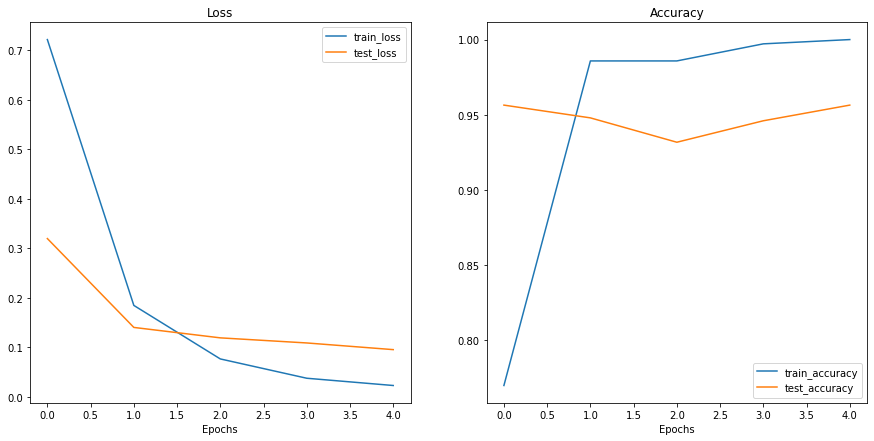

In [ ]:
plot_loss_curves(results=results)

Test Images and Plot Images

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

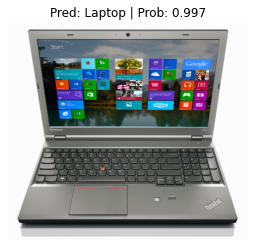

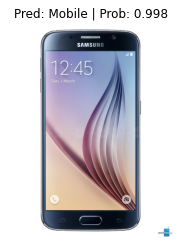

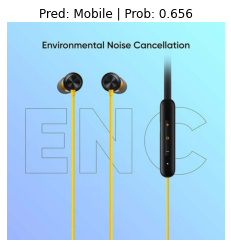

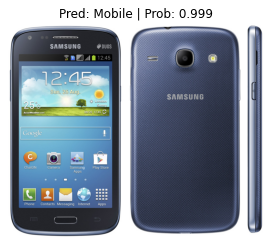

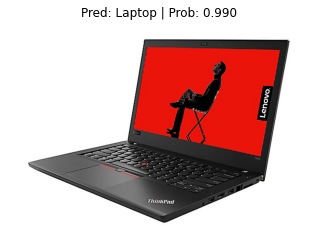

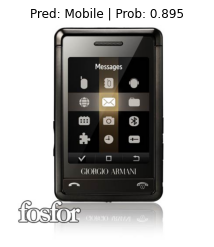

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 6
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=Gadgets_V1, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

Save Model

In [ ]:
def save_model(model:torch.nn.Module,
               target_dir:str,
               model_name:str):
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                      exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") 
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f" Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
            f=model_save_path)

In [ ]:
Gadgets_V1.to("cpu")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Predict Function for Gradio App

In [ ]:
from typing import Tuple, Dict
from timeit import default_timer as timer 

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    threshold=0.80
    
    # Transform the target image and add a batch dimension
    img = auto_transform(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    Gadgets_V1.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(Gadgets_V1(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter 
    y=(pred_probs>threshold).float()
    pred_prob=y.long()
    pred_prob=pred_prob.numpy()
    print(pred_prob)
    x=np.count_nonzero(pred_prob)
    print(x)
    if x==0:
      pred_labels_and_probs={"Unknown Images found":0}
    else:
      pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open("/content/drive/MyDrive/fees.jpg")
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /content/drive/MyDrive/ImagesD/test/Laptop/Image_1.jpg

[[0 0 0]]
0
Prediction label and probability dictionary: 
{'Unknown Images found': 0}
Prediction time: 0.16767 seconds


In [ ]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 14.8 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 2.3 MB 64.6 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 106 kB 67.0 MB/s 
     |████████████████████████████████| 212 kB 50.2 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 272 kB 67.5 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
     |████████████████████████████████| 80 kB 11.4 MB/s 
     |████████████████████████████████| 68 kB 7.9 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 856 kB 69.9 MB/s 
     |████████████████████████████████| 593 kB 7

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Gadgets Classifier 📱🖥🎧"
description = "An  computer vision model to classify images of Gadgets as Headphone, Laptop and Mobile."
article = "Created by Vishal Jadhav (www.linkedin.com/in/vishaljadhav1855)"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=["/content/drive/MyDrive/fees.jpg"], 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://05dc4df620ec743e.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f88eb6dbe90>,
 'http://127.0.0.1:7860/',
 'https://05dc4df620ec743e.gradio.app')

In [ ]:
save_model(model=Gadgets_V1,
           target_dir="/content/drive/MyDrive/ImagesD/Models",
           model_name="Gadgets_model_save.pth")

#Setup A Folder for the Deployement Purpose

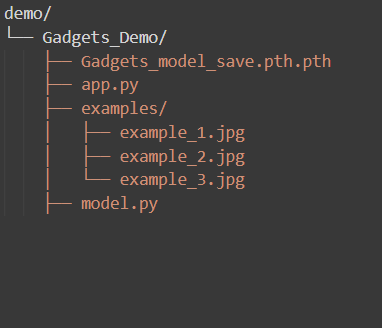

In [ ]:
import shutil
Gadgets_demo_path = Path("/content/drive/MyDrive/demo/Gadgets_Demo/")


if Gadgets_demo_path.exists():
    shutil.rmtree(Gadgets_demo_path)
    Gadgets_demo_path.mkdir(parents=True,
                                    exist_ok=True) 
else:
    Gadgets_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    


In [ ]:
Gadgets_examples_path = Gadgets_demo_path / "examples"
Gadgets_examples_path.mkdir(parents=True, exist_ok=True)

examples = [Path('/content/drive/MyDrive/ImagesD/test/Headphone/Headphones17.jpg'),
                            Path('/content/drive/MyDrive/ImagesD/test/Laptop/Image_16.jpg'),
                            Path('/content/drive/MyDrive/ImagesD/test/Mobile/Image_20.jpg')]

for example in examples:
    destination = Gadgets_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

In [ ]:
%%writefile /content/drive/MyDrive/demo/Gadgets_Demo/model.py
import torch
import torchvision

from torch import nn


def create_gadgets_model(num_classes:int=3, 
                          seed:int=42):
    # Create  pretrained weights, transforms and model
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.resnet50(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(in_features= 128,out_features=output_shape))
    
    return model, transforms

In [ ]:
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

In [ ]:
%%writefile /content/drive/MyDrive/demo/Gadgets_Demo/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_gadgets_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create model
gadget, gadget_transforms = create_gadgets_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
gadget.load_state_dict(
    torch.load(
        f="Gadgets_model_save.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = gadget_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    gadget.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(gadget(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Gadgets Classifier 📱🖥🎧"
description = "An  computer vision model to classify images of Gadgets as Headphone, Laptop and Mobile."
article = "Created by Vishal Jadhav (www.linkedin.com/in/vishaljadhav1855)"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

In [ ]:
%%writefile /content/drive/MyDrive/demo/Gadgets_Demo/requirements.txt
torch==1.12.1
torchvision==0.13.1
gradio==3.4.1

#Zipping The file

In [ ]:

!cd /content/drive/MyDrive/demo/Gadgets_Demo && zip -r ../Gadgets_Demo.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"
